In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Deep_Learning/Autism_dataset.zip -d dataset

Archive:  /content/drive/MyDrive/Deep_Learning/Autism_dataset.zip
   creating: dataset/Autism_dataset/armflapping/
  inflating: dataset/Autism_dataset/armflapping/AMF0.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF1.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF10.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF11.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF12.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF13.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF14.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF15.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF16.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF17.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF18.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF19.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF2.mp4  
  inflating: dataset/Autism_dataset/armflapping/AMF20.mp4  
  inflating: dataset/Autism_dataset/armflapping/

In [ ]:
!unzip /content/drive/MyDrive/Deep_Learning/Autism_dataset.zip -d /content/drive/MyDrive/Deep_Learning

Archive:  /content/drive/MyDrive/Deep_Learning/Autism_dataset.zip
   creating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF0.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF1.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF10.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF11.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF12.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF13.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF14.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF15.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping/AMF16.mp4  
  inflating: /content/drive/MyDrive/Deep_Learning/Autism_

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


# Import the necessary library for implementing the project

In [3]:
import cv2
import mediapipe as mp
import time
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import imutils
from google.colab.patches import cv2_imshow
from imutils import paths
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import seaborn as sns
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import random
from imutils.video import FPS
import os

# Preprocessing

In [4]:
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

## Feature extraction using media pipe library for each category(Armflapping,Headbanging,Spinning)

In [5]:
class poseDetector():
    def __init__(self, mode=False, upBody=False, complexity=1, smooth=True,
                 detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.upBody = upBody
        self.complexity = complexity
        self.smooth = smooth
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(self.mode, self.upBody, self.complexity,self.smooth,
                                     self.detectionCon, self.trackCon)
    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        if self.results.pose_landmarks:
            if draw:
                self.mpDraw.draw_landmarks(img, self.results.pose_landmarks,
                                           self.mpPose.POSE_CONNECTIONS)
        return img
    def findPosition(self, img, draw=True):
        self.lmList = []
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.lmList.append([cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 1, (255, 0, 0), cv2.FILLED)
        return self.lmList

In [7]:
filepath = list(paths.list_files("/content/drive/MyDrive/Deep_Learning/Autism_dataset/armflapping"))

for file in filepath:

    cap = cv2.VideoCapture(file)

    detector = poseDetector(complexity=2,detectionCon=0.5, trackCon=0.5)

    filename = file.split("_")[1]
    # print(filename)
    f = open('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/armflapping.txt', 'a+')
    while True:
        success, img = cap.read()

        if success == False:
            break
        sp = SimplePreprocessor(480,360)
        img = sp.preprocess(img)

        img = detector.findPose(img,draw=True)
        lmList = detector.findPosition(img, draw=True)

        for item in lmList:
            item = str(item).replace('[','').replace('] ',',')
            f.write("%s " % item)

        f.write("\n")

        # cv2_imshow(img)


In [8]:
filepath = list(paths.list_files("/content/drive/MyDrive/Deep_Learning/Autism_dataset/headbanging"))

for file in filepath:

    cap = cv2.VideoCapture(file)

    detector = poseDetector(complexity=2,detectionCon=0.5, trackCon=0.5)

    filename = file.split("_")[1]
    f = open('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/headbanging.txt', 'a+')
    while True:
        success, img = cap.read()

        if success == False:
            break
        sp = SimplePreprocessor(480,360)
        img = sp.preprocess(img)


        img = detector.findPose(img,draw=True)
        lmList = detector.findPosition(img, draw=True)

        for item in lmList:
            item = str(item).replace('[','').replace('] ',',')
            f.write("%s " % item)

        f.write("\n")

        # cv2_imshow(img)


In [10]:
filepath = list(paths.list_files("/content/drive/MyDrive/Deep_Learning/Autism_dataset/spinning"))

for file in filepath:

    cap = cv2.VideoCapture(file)

    detector = poseDetector(complexity=2,detectionCon=0.5, trackCon=0.5)

    filename = file.split("_")[1]
    # print(filename)
    f = open('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/spinning.txt', 'a+')
    while True:
        success, img = cap.read()

        if success == False:
            break
        sp = SimplePreprocessor(480,360)
        img = sp.preprocess(img)


        img = detector.findPose(img,draw=True)
        lmList = detector.findPosition(img, draw=True)

        for item in lmList:
            item = str(item).replace('[','').replace('] ',',')
            f.write("%s " % item)

        f.write("\n")

        # cv2_imshow(img)


In [11]:
filepath = list(paths.list_files("/content/drive/MyDrive/Deep_Learning/Autism_dataset/non_autism"))

for file in filepath:

    cap = cv2.VideoCapture(file)

    detector = poseDetector(complexity=2,detectionCon=0.5, trackCon=0.5)

    filename = file.split("_")[1]
    # print(filename)
    f = open('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/non_autism.txt', 'a+')
    while True:
        success, img = cap.read()

        if success == False:
            break
        sp = SimplePreprocessor(480,360)
        img = sp.preprocess(img)


        img = detector.findPose(img,draw=True)
        lmList = detector.findPosition(img, draw=True)

        for item in lmList:
            item = str(item).replace('[','').replace('] ',',')
            f.write("%s " % item)

        f.write("\n")

        # cv2_imshow(img)


# Txt file convert into csv

In [12]:
path = "/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/"
for txtfile in os.listdir(path):

    if txtfile.endswith('.txt'):

        # reading given csv file and creating dataframe
        websites = pd.read_csv(path+txtfile, header = None,
                               delimiter = ', | |\n|] |]')

        txtfile = txtfile.split(".")[0]
        websites.insert(66, "label", txtfile, True)
        # websites["label"] = "%s" % txtfile
        # store dataframe into csv file
        websites.to_csv('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/%s.csv' % txtfile,
                        index = None)

<ipython-input-12-3314dbe7689f>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  websites = pd.read_csv(path+txtfile, header = None,
<ipython-input-12-3314dbe7689f>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  websites = pd.read_csv(path+txtfile, header = None,
<ipython-input-12-3314dbe7689f>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  websites = pd.read_csv(path+txtfile, header = None,
<ipython-input-1

# concatenate the csv file

In [20]:
armflapping_df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/armflapping.csv")
headbanging_df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/headbanging.csv")
spinning_df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/spinning.csv")
non_autism_df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/non_autism.csv")
data = pd.concat([armflapping_df,headbanging_df,spinning_df,non_autism_df],axis=0)
data.drop("66",axis=1,inplace = True)
data.dropna(inplace = True)
data

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,label
0,234,156,248,106,261,103,272,100,201,111,...,1207.0,300.0,1223.0,107.0,1246.0,270.0,1281.0,127.0,1309.0,armflapping
1,234,155,248,106,261,103,272,100,201,109,...,1197.0,344.0,1175.0,152.0,1232.0,340.0,1235.0,189.0,1299.0,armflapping
2,234,151,248,104,261,101,272,98,201,106,...,1197.0,340.0,1186.0,149.0,1233.0,327.0,1244.0,182.0,1299.0,armflapping
3,234,150,248,103,261,99,272,97,201,105,...,1197.0,335.0,1195.0,143.0,1232.0,319.0,1250.0,172.0,1296.0,armflapping
4,234,147,248,100,261,97,272,94,202,103,...,1186.0,343.0,1195.0,153.0,1222.0,319.0,1243.0,183.0,1282.0,armflapping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,264,93,275,84,279,85,283,87,264,83,...,243.0,242.0,272.0,157.0,254.0,215.0,282.0,134.0,266.0,non_autism
2574,264,93,274,84,279,85,283,87,264,83,...,243.0,242.0,270.0,157.0,254.0,215.0,282.0,133.0,266.0,non_autism
2575,264,93,274,85,279,85,283,87,264,84,...,243.0,242.0,270.0,157.0,255.0,215.0,282.0,132.0,266.0,non_autism
2576,264,93,274,85,279,86,283,87,263,85,...,243.0,240.0,270.0,157.0,255.0,216.0,282.0,131.0,266.0,non_autism


In [21]:
data['label'].value_counts()

,count
label,
spinning,13572
armflapping,8832
headbanging,7582
non_autism,2578


In [22]:
# information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32564 entries, 0 to 2577
Data columns (total 67 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       32564 non-null  int64  
 1   1       32564 non-null  int64  
 2   2       32564 non-null  int64  
 3   3       32564 non-null  int64  
 4   4       32564 non-null  int64  
 5   5       32564 non-null  int64  
 6   6       32564 non-null  int64  
 7   7       32564 non-null  int64  
 8   8       32564 non-null  int64  
 9   9       32564 non-null  int64  
 10  10      32564 non-null  int64  
 11  11      32564 non-null  int64  
 12  12      32564 non-null  int64  
 13  13      32564 non-null  int64  
 14  14      32564 non-null  int64  
 15  15      32564 non-null  int64  
 16  16      32564 non-null  int64  
 17  17      32564 non-null  int64  
 18  18      32564 non-null  int64  
 19  19      32564 non-null  int64  
 20  20      32564 non-null  int64  
 21  21      32564 non-null  int64  
 22  22  

In [23]:
# description about dataset
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
count,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,...,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000,32564.000000
mean,228.738331,125.717142,232.602567,115.425009,235.492415,115.190364,238.244380,114.993336,224.894178,115.677712,...,223.068266,372.406983,252.060681,379.935020,225.223283,381.418806,246.678234,392.622098,220.734031,391.758875
std,70.068003,59.474697,71.834363,59.958293,72.573159,59.639775,73.455549,59.405668,71.068644,60.742903,...,125.412588,232.603767,131.103960,239.785366,128.904860,242.339457,137.907907,252.021396,135.197372,251.507920
min,-51.000000,-3.000000,-75.000000,-19.000000,-82.000000,-19.000000,-89.000000,-18.000000,-49.000000,-22.000000,...,-1666.000000,-1365.000000,-1442.000000,-1587.000000,-1746.000000,-1430.000000,-1560.000000,-1613.000000,-1787.000000,-1469.000000
25%,186.000000,82.000000,189.000000,72.000000,191.000000,72.000000,193.000000,72.000000,181.000000,72.000000,...,166.000000,237.000000,199.000000,243.000000,168.000000,243.000000,189.000000,251.000000,158.000000,250.000000
50%,231.000000,116.000000,236.000000,103.000000,238.000000,102.000000,241.000000,102.000000,228.000000,103.000000,...,215.000000,317.000000,254.000000,325.000000,220.000000,323.000000,250.000000,333.000000,213.000000,330.000000
75%,274.000000,154.000000,279.000000,143.000000,282.000000,143.000000,285.000000,143.000000,270.000000,143.000000,...,273.000000,411.000000,298.000000,423.000000,275.000000,421.000000,297.000000,436.000000,275.000000,433.000000
max,557.000000,533.000000,578.000000,512.000000,579.000000,508.000000,579.000000,503.000000,576.000000,530.000000,...,2156.000000,1854.000000,2170.000000,1994.000000,2247.000000,1924.000000,2259.000000,2021.000000,2301.000000,1982.000000


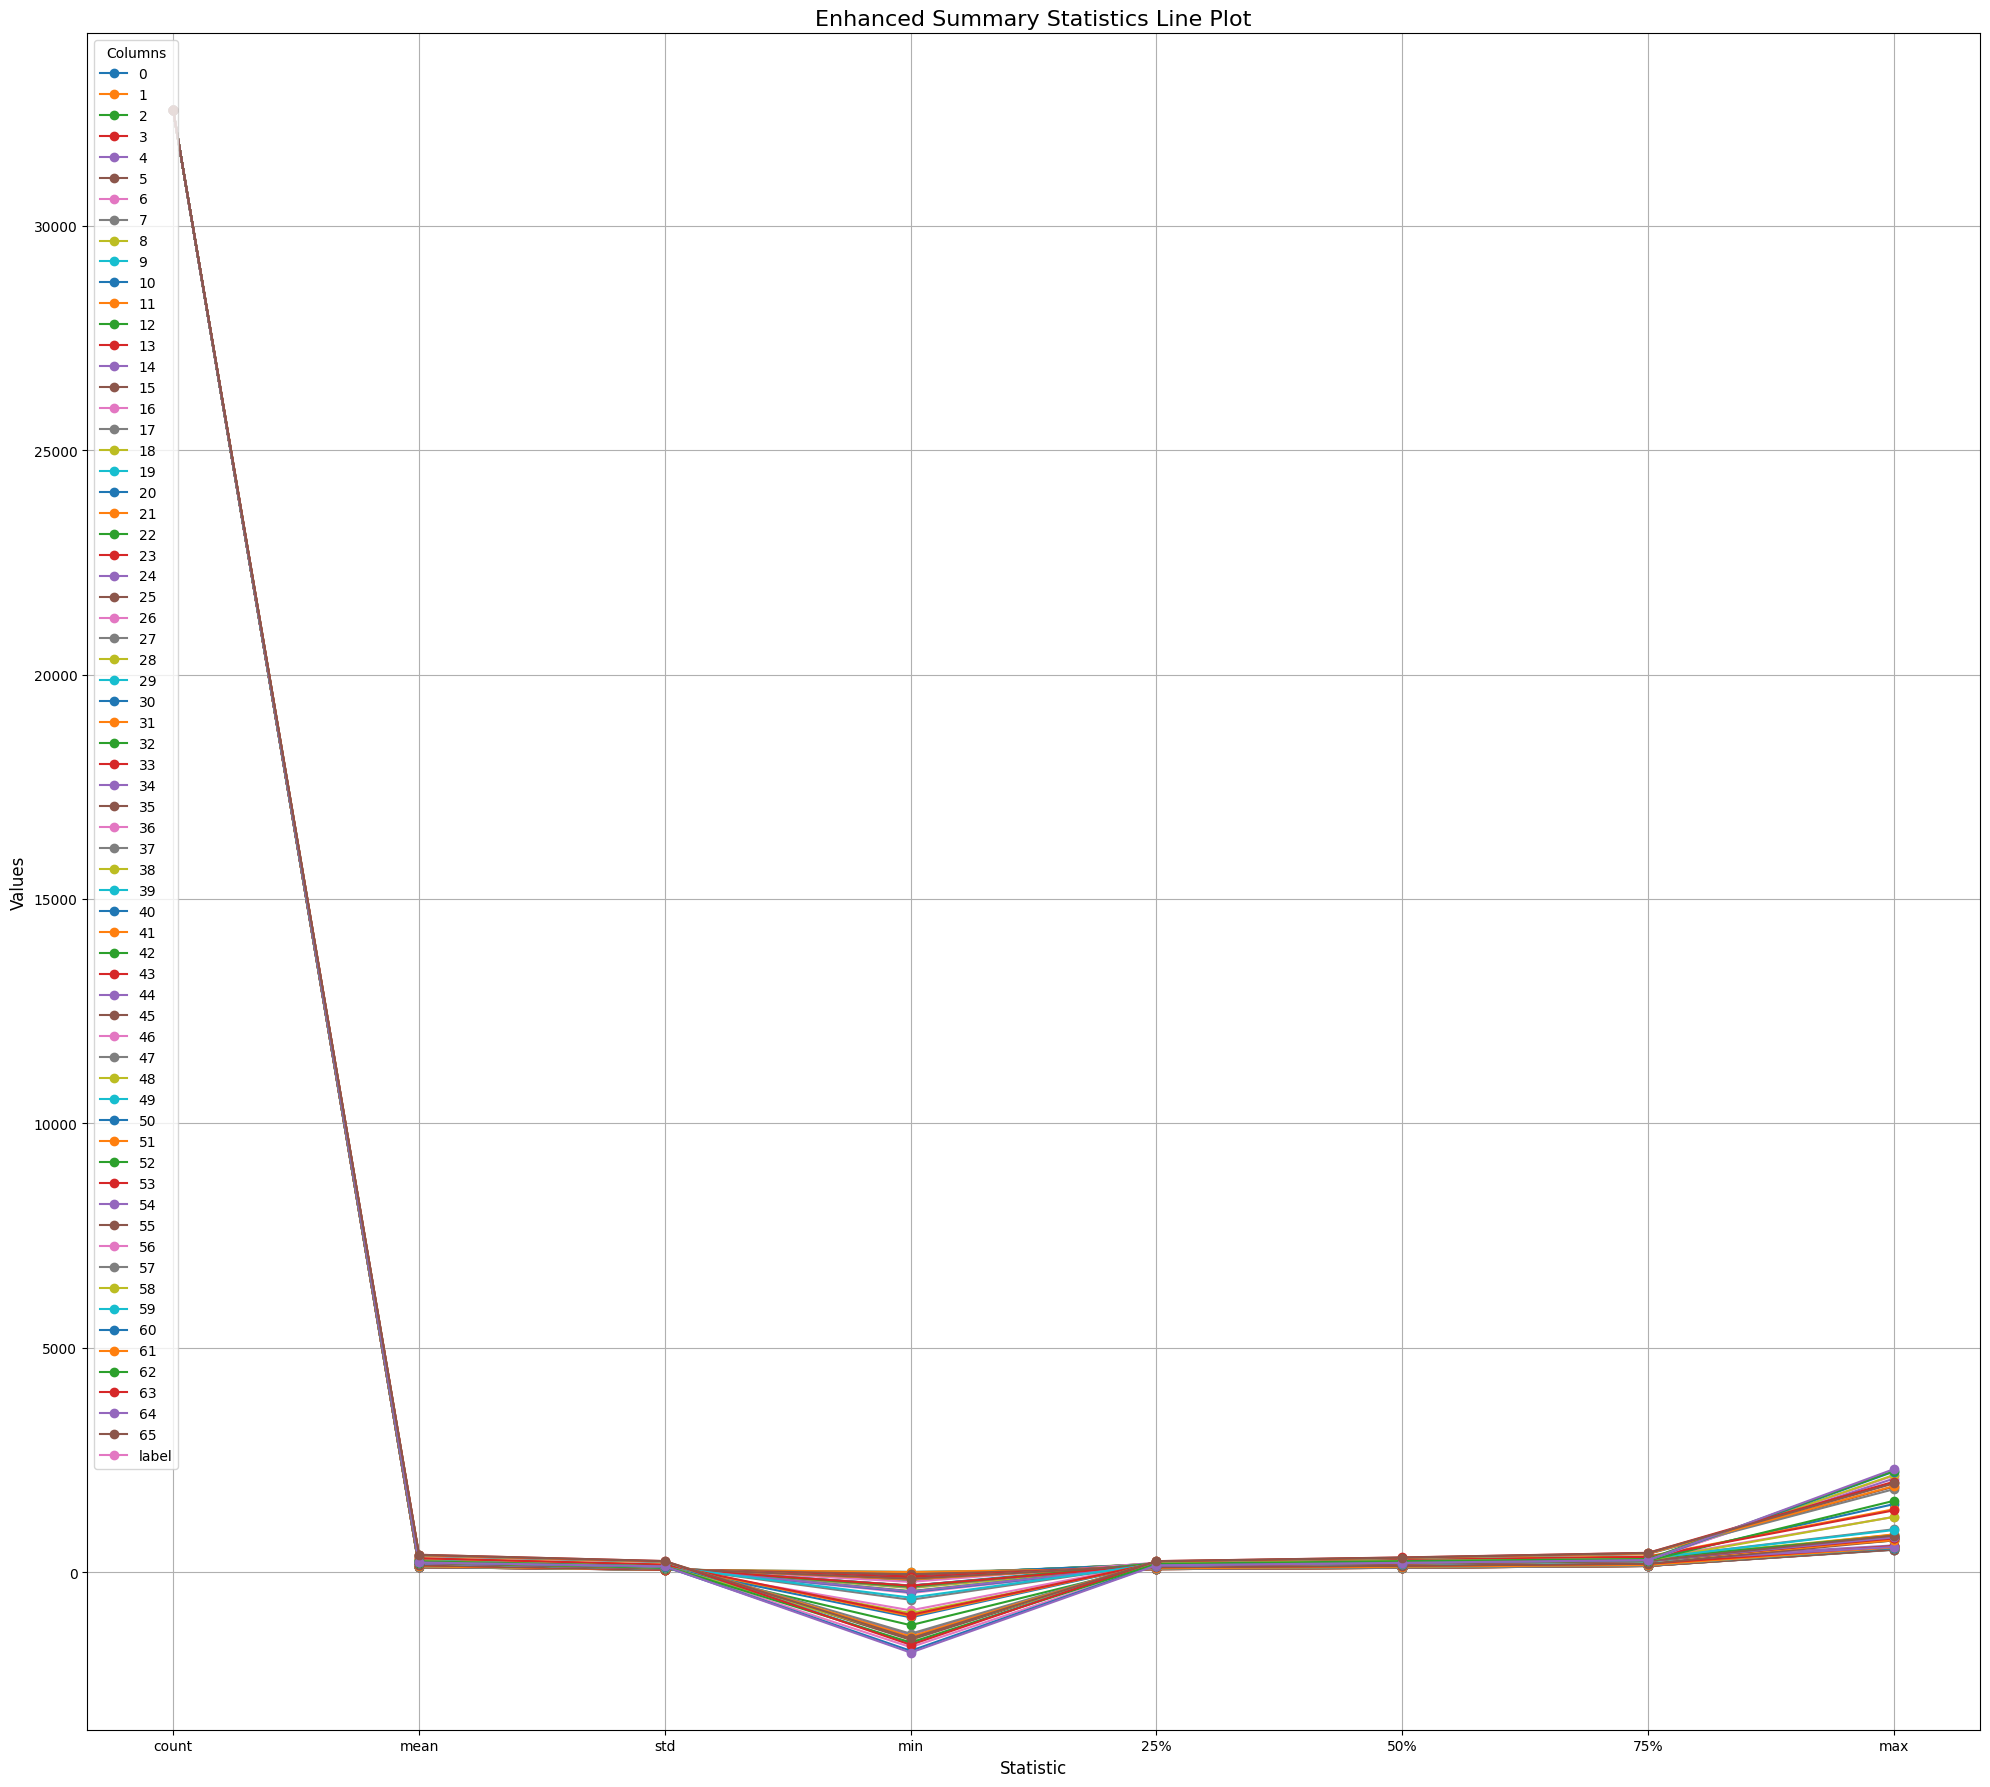

In [24]:

# Create a DataFrame containing summary statistics
summary_stats = data.describe()
summary_stats_df = pd.DataFrame(summary_stats, index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], columns=data.columns)

# Enhance the line plot
plt.figure(figsize=(20,18))

for column in summary_stats_df.columns:
    plt.plot(summary_stats_df.index, summary_stats_df[column], marker='o', label=column)

plt.title('Enhanced Summary Statistics Line Plot', fontsize=16)
plt.xlabel('Statistic', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Columns', loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [25]:
# count null value on each columns
data.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
62,0
63,0
64,0
65,0


# Classes convert into numeric format

In [26]:
# Map target String to Label
decode_map = {"armflapping":0, "headbanging":1,"non_autism":2,"spinning":3}
def decode_resolution(label):
    return decode_map[str(label)]

data[data.columns[-1]] = data[data.columns[-1]].apply(lambda x: decode_resolution(x))


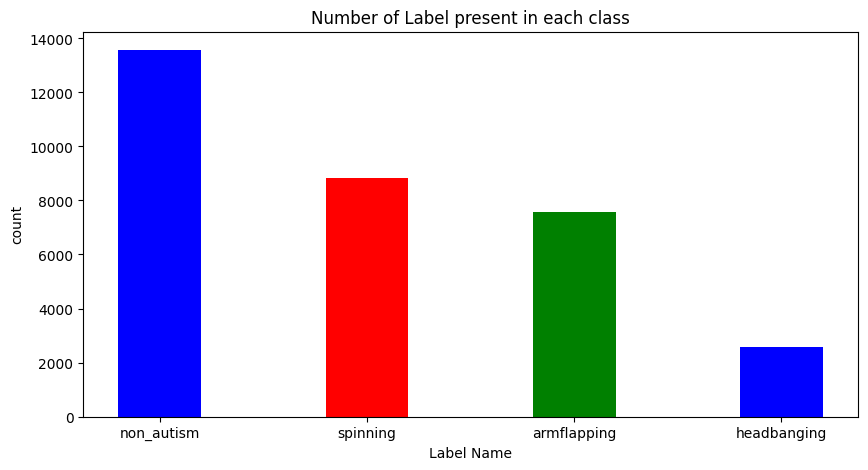

In [27]:
# Original dataset classes count
class_data = data['label'].value_counts()
# creating the dataset
labels_data = class_data.values
fig = plt.figure(figsize = (10, 5))

label_name = ['non_autism','spinning', 'armflapping','headbanging']
# creating the bar plot
plt.bar(label_name,labels_data , color=["blue","red","green"],
        width = 0.4)

plt.xlabel("Label Name")
plt.ylabel("count")
plt.title("Number of Label present in each class")
plt.show()

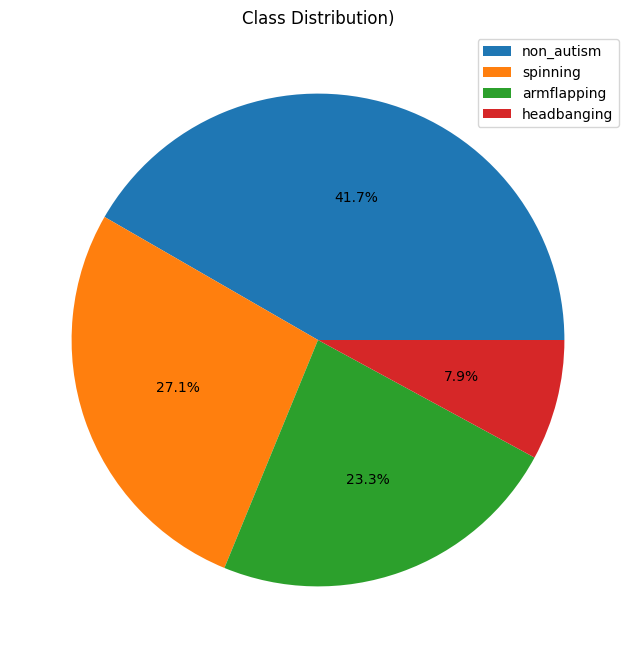

In [28]:
# Plot a pie chart for the class distribution
plt.figure(figsize=(10, 8))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=None)
plt.title('Class Distribution)')
plt.legend(labels=['non_autism','spinning', 'armflapping','headbanging'], loc='best')
plt.ylabel('')
plt.show()



In [30]:
X = data.iloc[:,:-1]
y= data.iloc[:,-1]

y

,label
0,0
1,0
2,0
3,0
4,0
...,...
2573,2
2574,2
2575,2
2576,2


In [31]:
from imblearn.over_sampling import SMOTE


smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)

# Now X_balanced and y_balanced contain the balanced dataset
# You can save them to a new CSV file if needed
balanced_data = pd.concat([pd.DataFrame(X_balanced), pd.DataFrame(y_balanced)], axis=1)
balanced_data.to_csv("/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/balanced_data.csv", index=False)


In [32]:
df_data = pd.read_csv('/content/drive/MyDrive/Deep_Learning/Autism_dataset/Extracted_data/balanced_data.csv')
df_data

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,label
0,234,156,248,106,261,103,272,100,201,111,...,1207.000000,300.000000,1223.000000,107.000000,1246.000000,270.000000,1281.000000,127.000000,1309.000000,0
1,234,155,248,106,261,103,272,100,201,109,...,1197.000000,344.000000,1175.000000,152.000000,1232.000000,340.000000,1235.000000,189.000000,1299.000000,0
2,234,151,248,104,261,101,272,98,201,106,...,1197.000000,340.000000,1186.000000,149.000000,1233.000000,327.000000,1244.000000,182.000000,1299.000000,0
3,234,150,248,103,261,99,272,97,201,105,...,1197.000000,335.000000,1195.000000,143.000000,1232.000000,319.000000,1250.000000,172.000000,1296.000000,0
4,234,147,248,100,261,97,272,94,202,103,...,1186.000000,343.000000,1195.000000,153.000000,1222.000000,319.000000,1243.000000,183.000000,1282.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54283,309,76,310,72,311,73,312,74,307,71,...,268.773191,255.226809,274.000000,190.773191,274.773191,275.453618,281.226809,193.144245,284.412336,2
54284,281,64,286,61,289,63,291,64,278,58,...,279.858747,244.000000,278.858747,187.141253,290.717493,256.282507,290.717493,166.858747,297.000000,2
54285,277,75,285,73,287,73,290,74,282,72,...,238.000000,253.000000,259.000000,224.093669,247.000000,235.000000,256.000000,193.093669,249.812661,2
54286,266,111,268,110,270,110,270,110,264,110,...,192.507431,289.238853,204.253716,249.477706,196.507431,300.477706,208.253716,246.462844,206.253716,2


In [33]:
df_data['label'].value_counts()

,count
label,
0,13572
1,13572
3,13572
2,13572


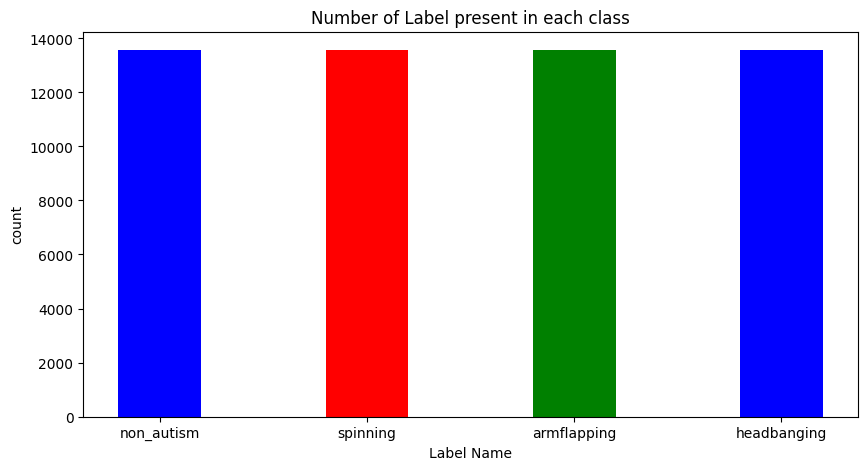

In [34]:
# Original dataset classes count
class_data = df_data['label'].value_counts()
# creating the dataset
labels_data = class_data.values
fig = plt.figure(figsize = (10, 5))

label_name = ['non_autism','spinning', 'armflapping','headbanging']
# creating the bar plot
plt.bar(label_name,labels_data , color=["blue","red","green"],
        width = 0.4)

plt.xlabel("Label Name")
plt.ylabel("count")
plt.title("Number of Label present in each class")
plt.show()

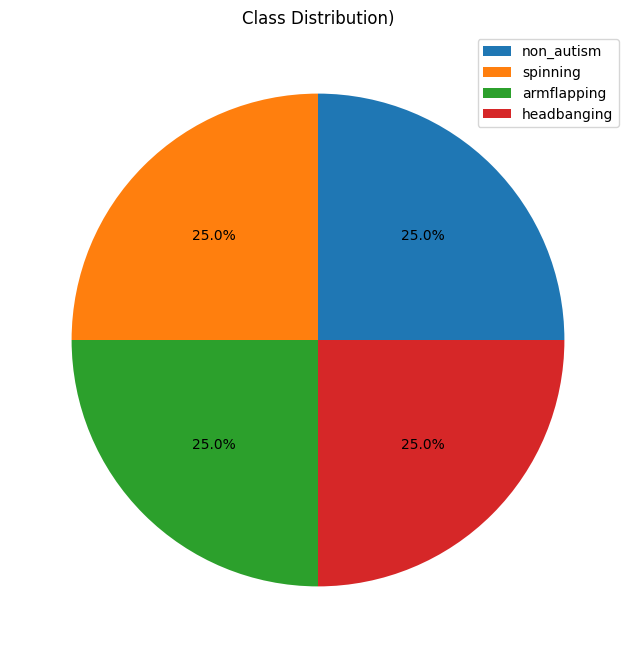

In [35]:
# Plot a pie chart for the class distribution
plt.figure(figsize=(10, 8))
df_data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=None)
plt.title('Class Distribution)')
plt.legend(labels=['non_autism','spinning', 'armflapping','headbanging'], loc='best')
plt.ylabel('')
plt.show()



In [36]:
X = df_data.iloc[:,:-1]
y = df_data.iloc[:,-1]

In [37]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
	test_size=0.20, random_state=42)

In [38]:
y_train_label = to_categorical(y_train)
y_test_label = to_categorical(y_test)

In [39]:
print('X_train',X_train.shape,'X_test',X_test.shape,'y_train',y_train.shape,'y_test',y_test.shape)

X_train (43430, 66) X_test (10858, 66) y_train (43430,) y_test (10858,)


In [41]:
train_val_data = {'total data':[len(X_train),len(X_test),len(y_train),len(y_test)]}
pd.DataFrame.from_dict(train_val_data, orient='index',columns=["X_train","X_test","y_train","y_test"])

,X_train,X_test,y_train,y_test
total data,43430,10858,43430,10858


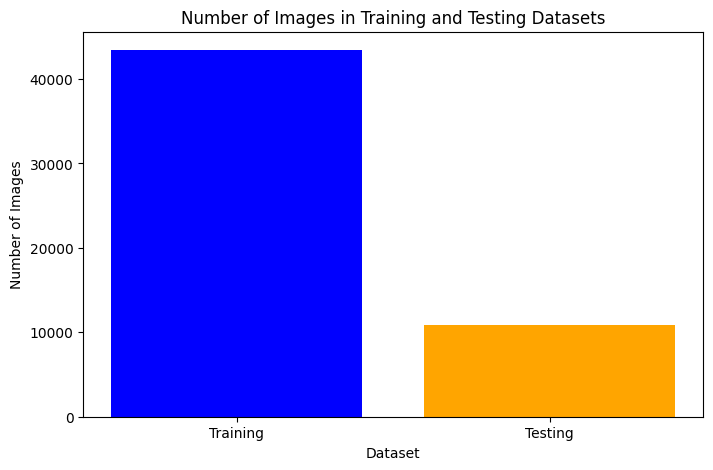

In [40]:
# Calculate the number of images for training and testing
num_train_images = len(X_train)
num_test_images = len(X_test)

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Training', 'Testing'], [num_train_images, num_test_images], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Training and Testing Datasets')
plt.show()


<ipython-input-42-8cb5a8b565e5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=train_data, palette=train_color, alpha=0.7, label='Training Set')
<ipython-input-42-8cb5a8b565e5>:10: UserWarning: The palette list has more values (43430) than needed (4), which may not be intended.
  sns.countplot(x='Class', data=train_data, palette=train_color, alpha=0.7, label='Training Set')
<ipython-input-42-8cb5a8b565e5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=test_data, palette=test_color, alpha=0.7, label='Testing Set')
<ipython-input-42-8cb5a8b565e5>:11: UserWarning: The palette list has more values (10858) than needed (4), which may not be intended.
  s

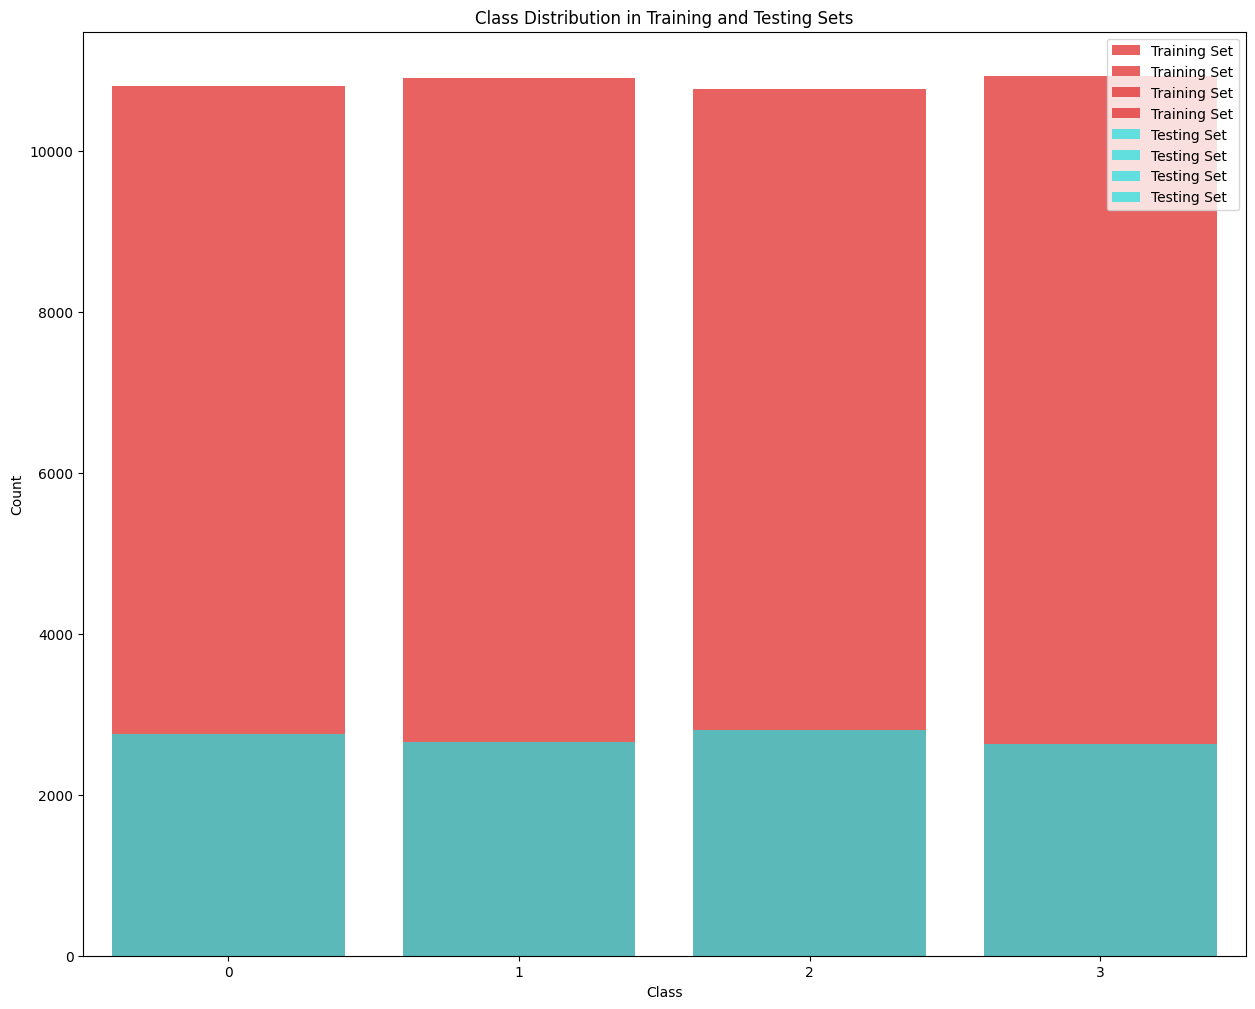

In [42]:
# Assuming you have y_train and y_test as 1-dimensional arrays
train_data = pd.DataFrame({'Class': y_train})
test_data = pd.DataFrame({'Class': y_test})

train_color = ["red"] * len(train_data)
test_color = ["cyan"] * len(test_data)

# Create a bar plot to visualize the class distribution in the training and testing sets
plt.figure(figsize=(15, 12))
sns.countplot(x='Class', data=train_data, palette=train_color, alpha=0.7, label='Training Set')
sns.countplot(x='Class', data=test_data, palette=test_color, alpha=0.7, label='Testing Set')
plt.title('Class Distribution in Training and Testing Sets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()


# Training using lstm algorithm

In [43]:
# build keras model
def Lstm_Algorithm():
    lstm = Sequential()
    lstm.add(Dense(units=189, activation='relu'))
    lstm.add(BatchNormalization())
    lstm.add(Dense(units=135, activation='relu'))
    lstm.add(BatchNormalization())
    lstm.add(Dense(units=81, activation='relu'))
    lstm.add(BatchNormalization())
    lstm.add(Dense(units=27, activation='relu'))
    lstm.add(BatchNormalization())
    lstm.add(Dense(units=9, activation='relu'))
    lstm.add(BatchNormalization())
    lstm.add(Dense(units=4, activation='softmax'))  # units = nums of classes

    return lstm

In [44]:
# Create the lstm_model
lstm_model = Lstm_Algorithm()

# Build the model
lstm_model.build(input_shape=(None,X_train.shape[1]))  # Replace input_dim with your input shape

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Print the model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 189)                 │          12,663 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 189)                 │             756 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 135)                 │          25,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 135)                 │             540 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 81)                  │          11,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 81)                  │             324 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │           2,214 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 27)                  │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │             252 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9)                   │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │              40 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,599 (209.37 KB)

 Trainable params: 52,717 (205.93 KB)

 Non-trainable params: 882 (3.45 KB)

In [48]:
checkpoint_filepath = '/content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras'
checkpointer = ModelCheckpoint(checkpoint_filepath, verbose=1, save_best_only=True, monitor='val_accuracy')
H = lstm_model.fit(X_train, y_train_label, batch_size=16, epochs=50, verbose=1, validation_data=(X_test, y_test_label), callbacks=[checkpointer])


Epoch 1/50
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6134 - loss: 0.9798
Epoch 1: val_accuracy improved from -inf to 0.84279, saving model to /content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.6135 - loss: 0.9797 - val_accuracy: 0.8428 - val_loss: 0.4821
Epoch 2/50
2708/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.5424
Epoch 2: val_accuracy improved from 0.84279 to 0.88755, saving model to /content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8105 - loss: 0.5423 - val_accuracy: 0.8875 - val_loss: 0.3467
Epoch 3/50
2696/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8462 - loss: 0.4437
Epoch 3: val_accuracy improved from 0.88755 to 0.90247, saving model to /content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8463 - loss: 0.4436

# Validation

In [49]:
from sklearn.metrics import classification_report
class_names = ["Armflapping","Headbanging","non autism","Spinning"]
print("[INFO] evaluating network...")
model_weight = load_model("/content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras")
predictions = model_weight.predict(X_test, batch_size=None)
print("Accuracy score of Lstm model:",round(accuracy_score(y_test_label.argmax(axis=1), predictions.argmax(axis=1)),2)*100)

[INFO] evaluating network...
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Accuracy score of Lstm model: 98.0


# Training and Validation Graph

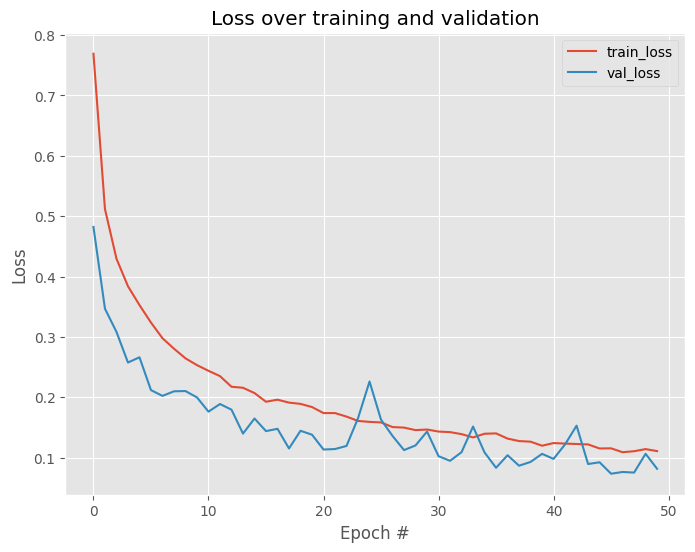

In [50]:
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.title("Loss over training and validation")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("loss.png")
plt.show()

# Training and validation Accuracy

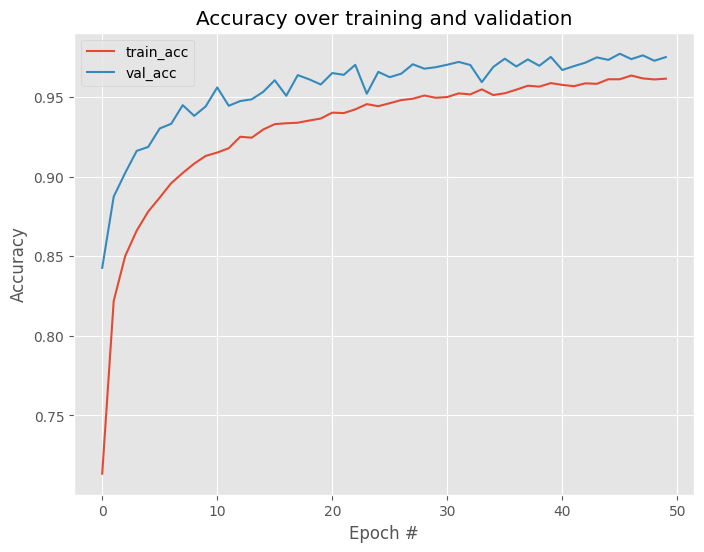

In [51]:
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy over training and validation")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig("accuracy.png")
plt.show()

# Classification Report

In [52]:
print("Classification Report:\n")
class_names = ["Armflapping","Headbanging","non autism","Spinning"]
print(classification_report(y_test_label.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

 Armflapping       0.97      0.97      0.97      2762
 Headbanging       0.97      0.97      0.97      2660
  non autism       1.00      1.00      1.00      2802
    Spinning       0.97      0.96      0.97      2634

    accuracy                           0.98     10858
   macro avg       0.98      0.98      0.98     10858
weighted avg       0.98      0.98      0.98     10858



# confusion matrix

Confusion Matrix:


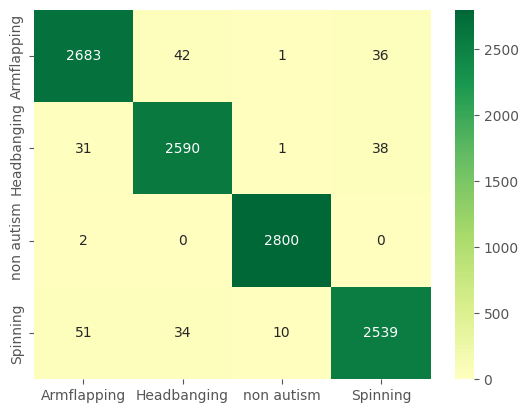

In [53]:
# Compute the error.
CM = confusion_matrix(y_test_label.argmax(axis=1), predictions.argmax(axis=1))
print('Confusion Matrix:')
# drawing confusion matrix
class_names = ["Armflapping","Headbanging","non autism","Spinning"]
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="RdYlGn",xticklabels = class_names,yticklabels = class_names)
plt.show()
print()

# Accuracy of an each class

In [54]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_label.argmax(axis=1), predictions.argmax(axis=1))

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_names = {0:"armflapping",1:"headbanging",2:"non autism",3:"spinning"}
class_accuracy_score = []
# Print accuracy for each class
for class_label, class_accuracy in enumerate(class_accuracies):
    class_accuracy_score.append(class_accuracy)
    class_name = class_names[class_label]
    print(f"Accuracy score of  {class_name}: is = {class_accuracy:.2f}")


Accuracy score of  armflapping: is = 0.97
Accuracy score of  headbanging: is = 0.97
Accuracy score of  non autism: is = 1.00
Accuracy score of  spinning: is = 0.96


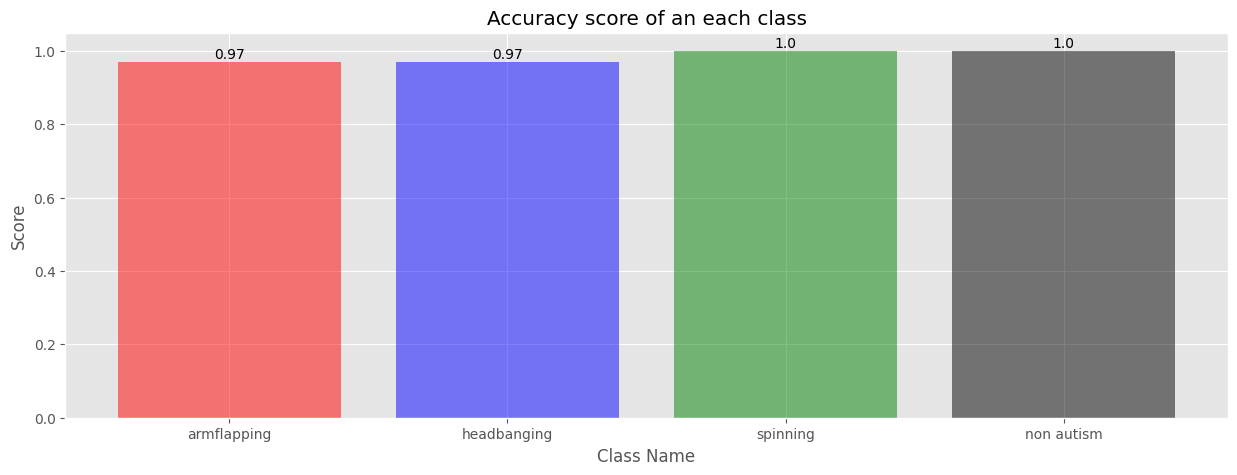

In [55]:
Accuracy = [round(class_accuracy_score[0],2),round(class_accuracy_score[1],2),round(class_accuracy_score[2],2), round(class_accuracy_score[2],2)]
objects =  ('armflapping','headbanging','spinning', 'non autism')
y_pos = np.arange(len(objects))
plt.figure(figsize = (15,5))
plt.bar(y_pos, Accuracy, align='center', alpha=0.5,color = ['red', 'blue', 'green', 'black'])
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.xlabel('Class Name')
plt.title('Accuracy score of an each class')

# Insert data labels above each bar
for i, value in enumerate(Accuracy):
    plt.text(i, value+0.01, str(value), ha='center')
plt.show()


# Roc curve

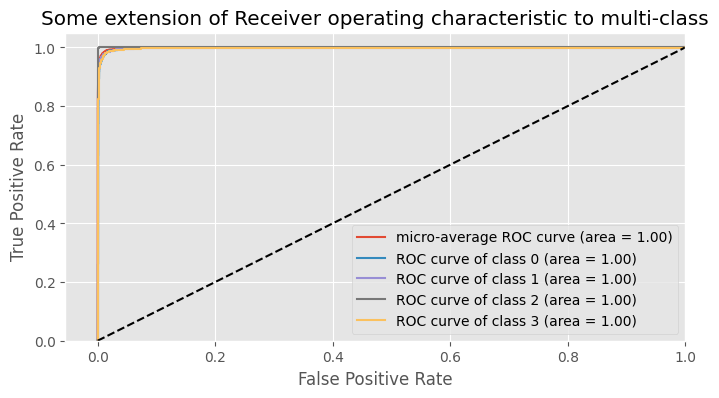

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ["armflapping", "headbanging", "non autism", "Spinning"]
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8,4))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.055, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [57]:
# metrics calculation
Accuracy_score = accuracy_score(y_test_label.argmax(axis=1), predictions.argmax(axis=1))
Precision_score = precision_score(y_test_label.argmax(axis=1), predictions.argmax(axis=1),average = "weighted")
Recall_score = recall_score(y_test_label.argmax(axis=1), predictions.argmax(axis=1),average = "weighted")
F1_score = f1_score(y_test_label.argmax(axis=1), predictions.argmax(axis=1),average = "weighted")

In [58]:
lstm_metrics = [Accuracy_score,Precision_score,Recall_score,F1_score]

metrics = {"Lstm metrics":lstm_metrics}
pd.DataFrame.from_dict(metrics, orient='index',columns=['accuracy',"precision","recall","f1-score"])

,accuracy,precision,recall,f1-score
Lstm metrics,0.977344,0.977323,0.977344,0.977328


# Lstm model metrics comparison

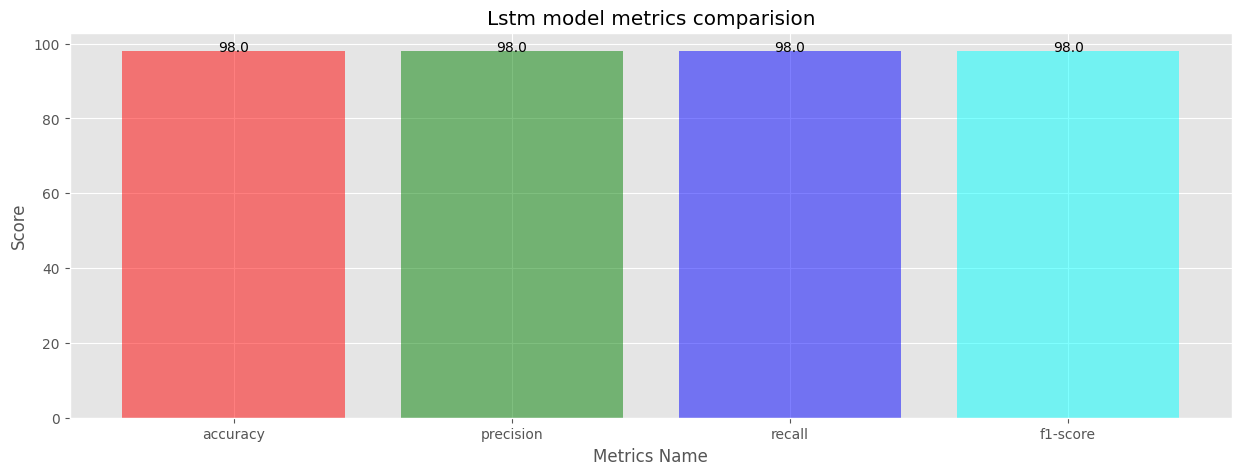

In [59]:
Accuracy = [round(Accuracy_score,2)*100,round(Precision_score,2)*100,round(Recall_score,2)*100,round(F1_score,2)*100]
objects =  ('accuracy',"precision","recall","f1-score")
y_pos = np.arange(len(objects))
plt.figure(figsize = (15,5))
plt.bar(y_pos, Accuracy, align='center', alpha=0.5,color = ['red', 'green', 'blue','cyan'])
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.xlabel('Metrics Name')
plt.title('Lstm model metrics comparision')

# Insert data labels above each bar
for i, value in enumerate(Accuracy):
    plt.text(i, value+0.01, str(value), ha='center')
plt.show()


### Prediction

In [62]:
class poseDetector():
    def __init__(self, mode=False, upBody=False, complexity=1, smooth=True,
                 detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.upBody = upBody
        self.complexity = complexity
        self.smooth = smooth
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(self.mode, self.upBody, self.complexity,self.smooth,
                                     self.detectionCon, self.trackCon)
    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        if self.results.pose_landmarks:
            if draw:
                self.mpDraw.draw_landmarks(img, self.results.pose_landmarks,
                                           self.mpPose.POSE_CONNECTIONS)
        return img
    def findPosition(self, img, draw=True):
        self.lmList = []
        self.lmList_ = []
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.lmList.append([id, cx, cy])
                self.lmList_.append(cx)
                self.lmList_.append(cy)
                if draw:
                    cv2.circle(img, (cx, cy), 1, (255, 0, 0), cv2.FILLED)
        return self.lmList, self.lmList_

In [66]:
import warnings
warnings.filterwarnings("ignore")

#arm flapping
right_arm = 0
left_arm = 0
updownr_arm = 0
updownl_arm = 0
lr_arm = []

# head banging
updown_head = 0
leftright_head = 0
ud_head = []

# spinning
x = 0

model = load_model("/content/drive/MyDrive/Deep_Learning/Autism_dataset/model_file.keras")
fname = "/content/drive/MyDrive/Deep_Learning/Autism_dataset/headbanging/HB10.mp4"
cap = cv2.VideoCapture(fname)

detector = poseDetector()
length = []

if os.path.exists("testing.txt"):
  os.remove("testing.txt")
f = open('testing.txt', 'a+')
while True:
    success, img = cap.read()

    length.append(success)
    if len(length) == 420:
        break
    elif success == False:
        break

    img = cv2.resize(img, (480,360))
    img = detector.findPose(img, draw=True)
    lmList, lmList_ = detector.findPosition(img, draw=False)

    for item in lmList_:
        item = str(item).replace('[','').replace('] ',',')
        f.write("%s " % item)

    f.write("\n")
    # cv2_imshow(img)

    if len(lmList) != 0:

        # banging up and down
        diff_head_y = lmList[0][2] - updown_head
        updown_head = lmList[0][2]
        ud_head.append(abs(diff_head_y))

        diff_head_x = lmList[0][1] - leftright_head
        leftright_head = lmList[0][1]
        ud_head.append(abs(diff_head_x))

        # flapping right&left
        diff_arm = lmList[20][1] - right_arm
        right_arm = lmList[20][1]
        lr_arm.append(abs(diff_arm))

        diff_arm_left = lmList[19][1] - left_arm
        left_arm = lmList[19][1]
        lr_arm.append(abs(diff_arm_left))

        # flapping updown right&left
        diff_udr_arm = lmList[20][2] - updownr_arm
        updownr_arm = lmList[20][2]
        lr_arm.append(abs(diff_udr_arm))

        diff_udl_arm = lmList[19][2] - updownl_arm
        updownl_arm = lmList[19][2]
        lr_arm.append(abs(diff_udl_arm))

        # spinning
        diff = lmList[11][1] - lmList[12][1]
        if abs(diff) > 0 and abs(diff) < 4:
            x += 1

 # reading given csv file and creating dataframe
websites = pd.read_csv("testing.txt", header = None,
                        delimiter = ', | |\n|] |]')
print(len(websites))
websites = websites.iloc[1:-1]

class_names = ["Armflapping","Headbanging","non autism","Spinning"]

pred = model.predict(websites)
xy = []
z = []
for i in pred:
    xy.append(np.argmax(i))
    z.append(max(i))

most_common_item = max(xy, key = xy.count)
prediction = class_names[most_common_item]
print()
prob = round((sum(z)/len(z) *100), 2)
print("Probability of is " + prediction, str(prob) + "%")



405
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

Probability of is Headbanging 99.62%
405
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Probability of is Headbanging 99.62%
